In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

IPythonConsole.ipython_useSVG = False
DrawingOptions.includeAtomNumbers = False

def get_locked_ids(mol):
    return [idx for idx, atm in enumerate(mol.atoms) if atm.is_locked]

def depict(mol):
    rd_mol = mol.asRDMol()
    
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    
    # include atom indices
    opts = drawer.drawOptions()
    for i in range(rd_mol.GetNumAtoms()):
        opts.atomLabels[i] = str(i+1)
    
    # draw the molecule as SVG
    drawer.DrawMolecule(
        rd_mol
        , highlightAtoms=get_locked_ids(mol)
    )
    drawer.FinishDrawing()
    return SVG(drawer.GetDrawingText().replace('svg:',''))

def get_locked_atoms(mol):
    return [(idx, atm) for idx, atm in enumerate(mol.atoms) if atm.is_locked]

def as_mol_grid(mols):
    locked_atoms = [[y[0] for y in get_locked_atoms(x)] for x in mols]
    return MolsToGridImage(
        [x.asRDMol() for x in mols]
        , subImgSize=(250,200)
        , highlightAtomLists=locked_atoms
        , legends=[x.parent_operator for x in mols]
    )

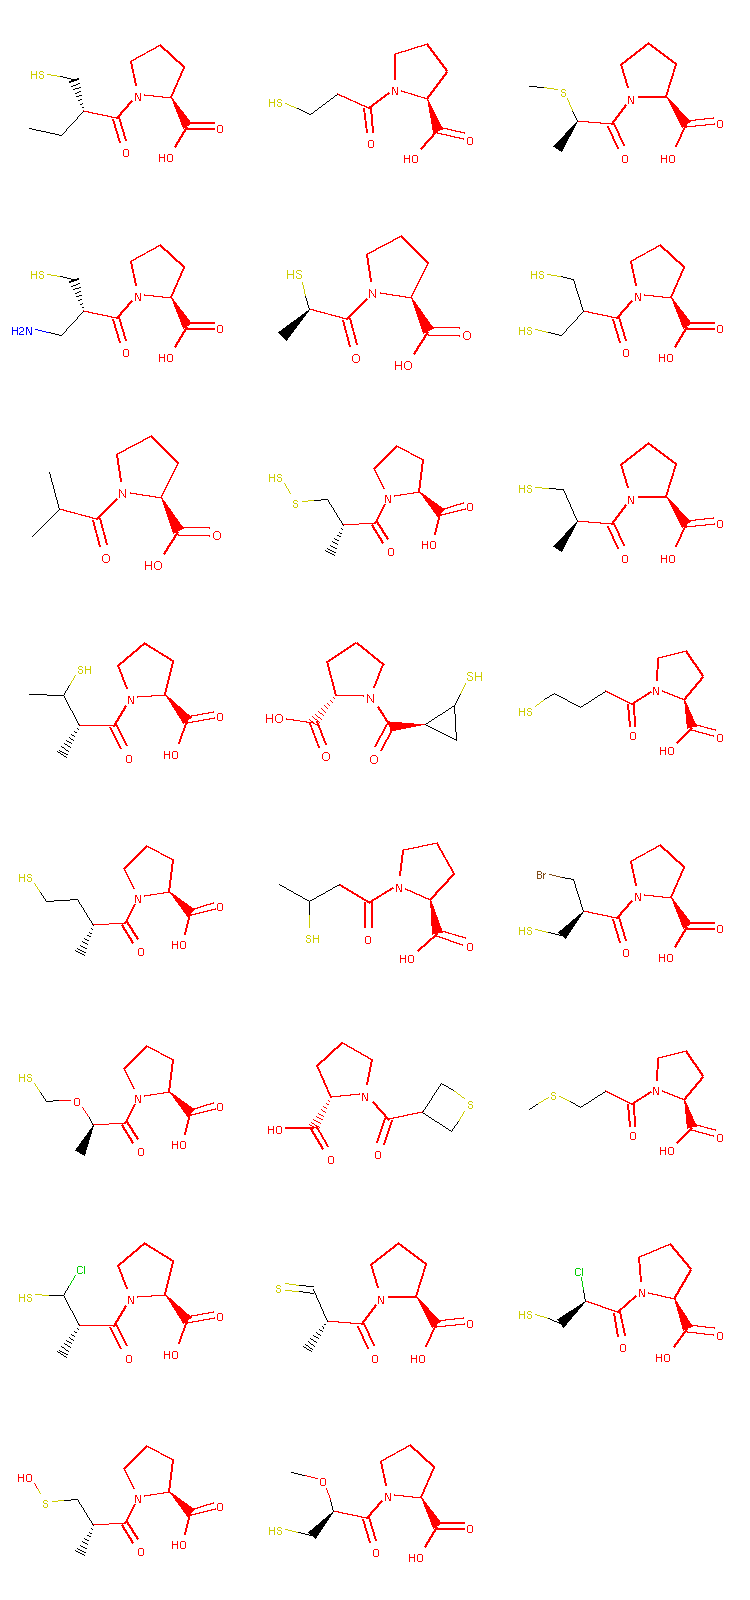

In [2]:
from rdkit import Chem
from molpher.core import MolpherMol
from molpher.core.morphing import Molpher
from molpher.core.morphing.operators import *

# define a collector -> a callback function that processes morphs as they are generated
strange_patterns = Chem.MolFromSmarts('[S,O,N][F,Cl,Br,I]')
sensible_morphs = dict()
def collect_sensible(morph, operator):
    """
    simple collector, accepts morphs without weird structural patterns
    """

    rd_morph = morph.asRDMol()
    if not rd_morph.HasSubstructMatch(strange_patterns):
        sensible_morphs[morph.smiles] = morph

# load a molecule from SDF and generate some derived molecules with given morphing operators 
mol = MolpherMol("captopril.sdf")
molpher = Molpher(
    mol
    , [ # list of morphing operators to use
        AddAtom()
        , RemoveAtom()
        , MutateAtom()
        , AddBond()
        , RemoveBond()
        , ContractBond()
        , InterlayAtom()
        , RerouteBond()
    ]
    , attempts = 100 # create at most 100 molecules
    , collectors = [collect_sensible]
)

# execute morphing and show created molecules
molpher()
as_mol_grid(sensible_morphs.values()) # draw generated structures in a grid

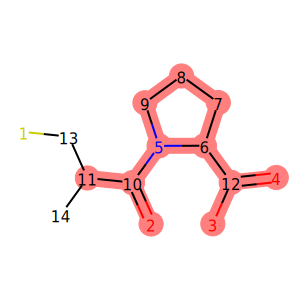

In [3]:
depict(mol)

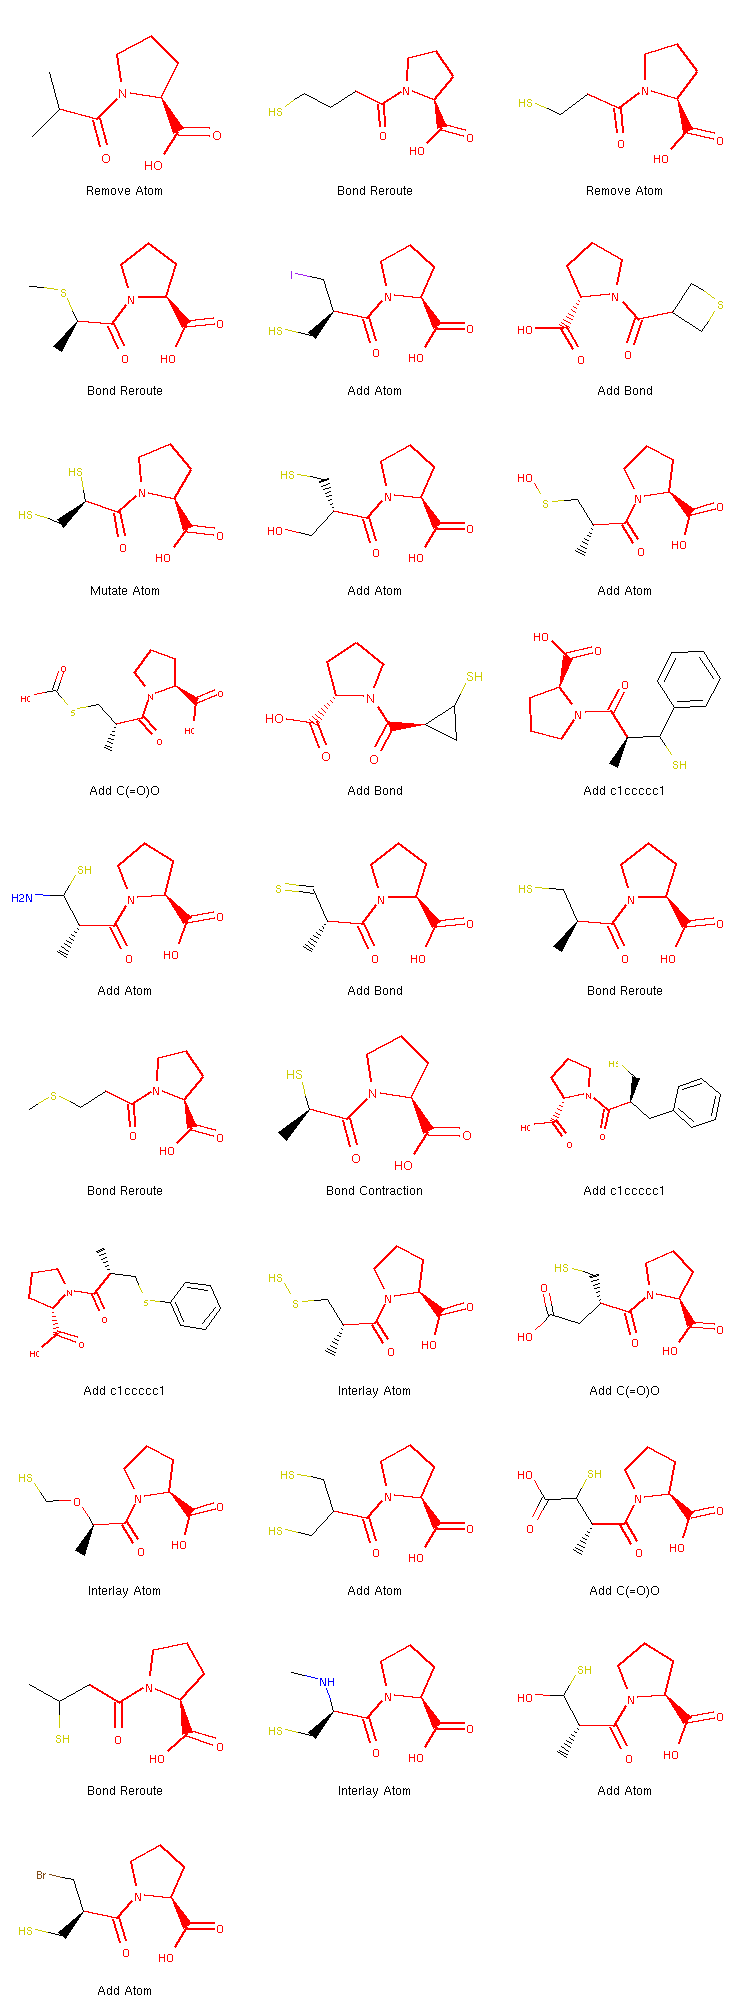

In [4]:
from rdkit import Chem
from molpher.core import MolpherMol, MolpherAtom
from molpher.core.morphing import Molpher
from molpher.core.morphing.operators import *
from molpher.random_numbers import get_random_number

class AddFragment(MorphingOperator):
    """
    Attaches a given molecule fragment to an atom in the molecule.
    """

    def __init__(self, fragment, open_atoms_frag, oper_name):
        super(AddFragment, self).__init__()
        self._name = oper_name # name of the operator
        self._fragment = fragment # fragment as RDKit Mol
        self._open_atoms_frag = open_atoms_frag # possible attachment positions on the fragment
        self._orig_rdkit = None # original molecule as RDKit Mol
        self._open_atoms = [] # possible attachment positions on the original molecule

    def setOriginal(self, mol):
        super(AddFragment, self).setOriginal(mol)
        if self.original:
            self._orig_rdkit = self.original.asRDMol()
            self._open_atoms = []

            for atm_rdkit, atm_molpher in zip(self._orig_rdkit.GetAtoms(), self.original.atoms):
                free_bonds = atm_rdkit.GetImplicitValence()
                if free_bonds >= 1 and not (MolpherAtom.NO_ADDITION & atm_molpher.locking_mask):
                    self._open_atoms.append(atm_rdkit.GetIdx())

    def morph(self):
        combo_mol = Chem.EditableMol(Chem.CombineMols(
            self._orig_rdkit
            , self._fragment
        ))
        atom_orig = self._open_atoms[get_random_number(0, len(self._open_atoms)-1)]
        atom_frag = len(self.original.atoms) + self._open_atoms_frag[get_random_number(0, len(self._open_atoms_frag)-1)]
        combo_mol.AddBond(atom_orig, atom_frag, order=Chem.rdchem.BondType.SINGLE)
        combo_mol = combo_mol.GetMol()
        Chem.SanitizeMol(combo_mol)

        ret = MolpherMol(other=combo_mol)
        for atm_ret, atm_orig in zip(ret.atoms, self.original.atoms):
            atm_ret.locking_mask = atm_orig.locking_mask

        return ret

    def getName(self):
        return self._name

# define a collector -> a callback function that processes morphs as they are generated
strange_patterns = Chem.MolFromSmarts('[S,O,N][F,Cl,Br,I]')
sensible_morphs = dict()
def collect_sensible(morph, operator):
    """
    simple collector, accepts morphs without weird structural patterns
    """

    rd_morph = morph.asRDMol()
    if not rd_morph.HasSubstructMatch(strange_patterns):
        sensible_morphs[morph.smiles] = morph
        morph.parent_operator = operator.getName()

# create some AddFragment operators
fragments = ['c1ccccc1', 'C(=O)O']
add_frags = []
for frag in fragments:
    add_frag = AddFragment(Chem.MolFromSmiles(frag), [0], "Add " + frag)
    add_frags.append(add_frag)

# load a molecule from SDF and generate some derived molecules with given morphing operators 
mol = MolpherMol("captopril.sdf")
molpher = Molpher(
    mol
    , [ # list of morphing operators to use
        AddAtom()
        , RemoveAtom()
        , MutateAtom()
        , AddBond()
        , RemoveBond()
        , ContractBond()
        , InterlayAtom()
        , RerouteBond()
    ] + add_frags # add our custom operators, too
    , attempts = 100 # create at most 100 molecules
    , collectors = [collect_sensible]
)

# execute morphing and show created molecules
molpher()
as_mol_grid(sensible_morphs.values()) # draw generated structures in a grid

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


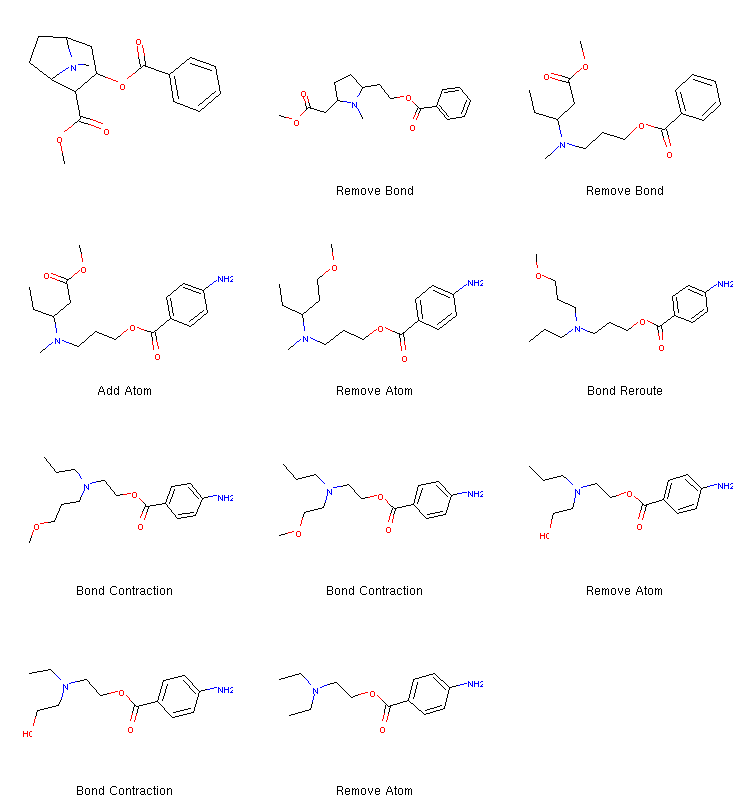

In [6]:
from molpher.core import ExplorationTree as ETree
from molpher.algorithms.functions import find_path

cocaine = 'CN1C2CCC1C(C(=O)OC)C(OC(=O)c1ccccc1)C2'
procaine = 'O=C(OCCN(CC)CC)c1ccc(N)cc1'

tree = ETree.create(source=cocaine, target=procaine) # create the tree
counter = 0
while not tree.path_found:
    counter+=1
    print("Iteration", counter)
    tree.generateMorphs() # generate the first generation of morphs
    tree.sortMorphs() # sort morphs according to their distance to target (ascending)
    tree.filterMorphs() # remove molecules that do not meet certain criteria
    tree.extend() # connect the remaining molecules to the exploration tree
    tree.prune() # remove branches of the tree that do not converge

as_mol_grid(tree.fetchPathTo(tree.params['target']))